In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pickle

pd.options.display.max_columns = None
sns.set_style('ticks')
plt.style.use('seaborn')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Import Data

## TripAdvisor

In [2]:
reviews_ta = pd.read_csv('./Data/MOH_TA_REVIEWS.csv')
print(reviews_ta.shape)

(10335, 6)


In [3]:
# remove leading and trailing whitespaces
reviews_ta = reviews_ta.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [4]:
# convert hotel response to binary
reviews_ta['hotel_response'] = np.where(reviews_ta['hotel_response'].notnull(), 1, 0)

In [5]:
# get date out from date_of_stay
reviews_ta['date_of_stay'] = reviews_ta['date_of_stay'].str.split(": ", expand = True)[1]
reviews_ta['month_of_stay'] = reviews_ta['date_of_stay'].str.split(" ", expand = True)[0]
reviews_ta['year_of_stay'] = reviews_ta['date_of_stay'].str.split(" ", expand = True)[1]

In [6]:
# convert date_of_stay to date format and reset index
reviews_ta['date_of_stay'] = pd.to_datetime(reviews_ta['date_of_stay']).dt.to_period('m')
reviews_ta = reviews_ta.sort_values('date_of_stay', ascending=False).reset_index(drop=True)

In [7]:
# drop date_of_review
reviews_ta.drop('date_of_review', axis=1, inplace=True)

In [8]:
# combine review_title and review
reviews_ta['review'] = reviews_ta['review_title'] + ' ' + reviews_ta['review']
reviews_ta.drop('review_title', axis=1, inplace=True)

In [9]:
# clean trip_type
reviews_ta['trip_type'] = reviews_ta['trip_type'].str.split(": ", expand = True)[1]

In [10]:
# add source column (for ref later when concat)
reviews_ta['source'] = 'TripAdvisor'

In [11]:
# drop null reviews and null date
reviews_ta = reviews_ta[reviews_ta['review'].notnull()]
reviews_ta = reviews_ta[reviews_ta['date_of_stay'].notnull()]

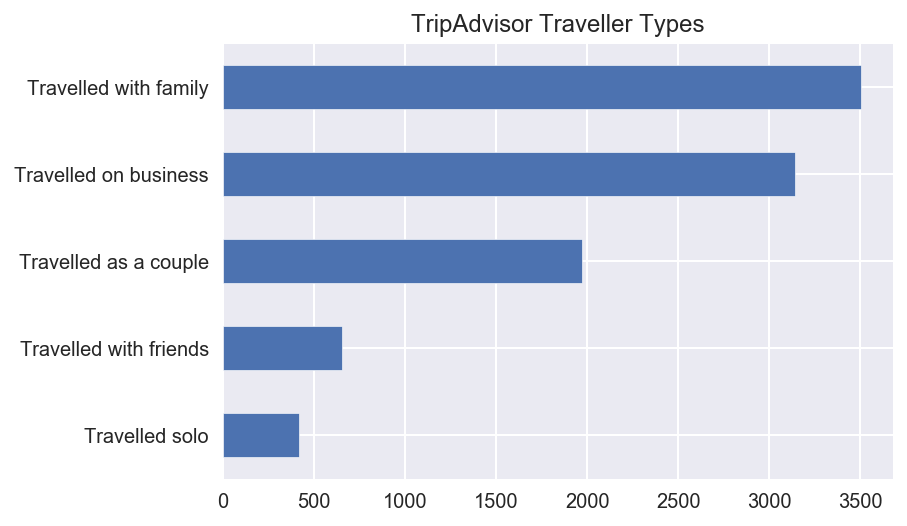

In [12]:
pd.Series(reviews_ta['trip_type']).value_counts().sort_values(ascending=True).plot('barh')
plt.title('TripAdvisor Traveller Types')
plt.show()

In [13]:
reviews_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10328 entries, 0 to 10331
Data columns (total 7 columns):
date_of_stay      10328 non-null period[M]
trip_type         9686 non-null object
review            10328 non-null object
hotel_response    10328 non-null int64
month_of_stay     10328 non-null object
year_of_stay      10328 non-null object
source            10328 non-null object
dtypes: int64(1), object(5), period[M](1)
memory usage: 645.5+ KB


In [14]:
reviews_ta.head(3)

,date_of_stay,trip_type,review,hotel_response,month_of_stay,year_of_stay,source
0,2019-05,Travelled on business,Expensive and not worth it !! stayed their for...,1,May,2019,TripAdvisor
1,2019-05,NaN,Best location in Singapore Have been staying i...,1,May,2019,TripAdvisor
2,2019-05,NaN,Excellent hotel service Superb location right ...,1,May,2019,TripAdvisor


- tripadvisor date_of_stay range = oct 2004 to may 2019

## Agoda

In [15]:
reviews_agd = pd.read_csv('./Data/MOH_AGODA_REVIEWS.csv')
print(reviews_agd.shape)

(10000, 6)


In [16]:
# remove leading and trailing whitespaces
reviews_agd = reviews_agd.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [17]:
# drop duplicate jobs (53 dropped)
reviews_agd.drop_duplicates(keep='first', inplace=True)
reviews_agd.shape

(9947, 6)

In [18]:
# remove inconsistent date_of_stay (not starting with 'Stayed x nights')
reviews_agd = reviews_agd[~reviews_agd['date_of_stay'].str.contains('Reviewed')]

In [19]:
# get date out from date_of_stay
reviews_agd['date_of_stay'] = reviews_agd['date_of_stay'].str.split("in ", expand = True)[1]
reviews_agd['month_of_stay'] = reviews_agd['date_of_stay'].str.split(" ", expand = True)[0]
reviews_agd['year_of_stay'] = reviews_agd['date_of_stay'].str.split(" ", expand = True)[1]

In [20]:
# convert date_of_stay to date format and reset index
reviews_agd['date_of_stay'] = pd.to_datetime(reviews_agd['date_of_stay']).dt.to_period('m')
reviews_agd = reviews_agd.sort_values('date_of_stay', ascending=False).reset_index(drop=True)

In [21]:
# drop date_of_review
reviews_agd.drop('date_of_review', axis=1, inplace=True)

In [22]:
# combine review and review_title
reviews_agd['review'] = reviews_agd['review_title'] + ' ' + reviews_agd['review']
reviews_agd.drop('review_title', axis=1, inplace=True)

In [23]:
# clean nationality
reviews_agd['nationality'] = reviews_agd['nationality'].str.split("from ", expand = True)[1]

In [24]:
# add source column (for ref later when concat)
reviews_agd['source'] = 'Agoda'

In [25]:
# drop null reviews
reviews_agd = reviews_agd[reviews_agd['review'].notnull()]

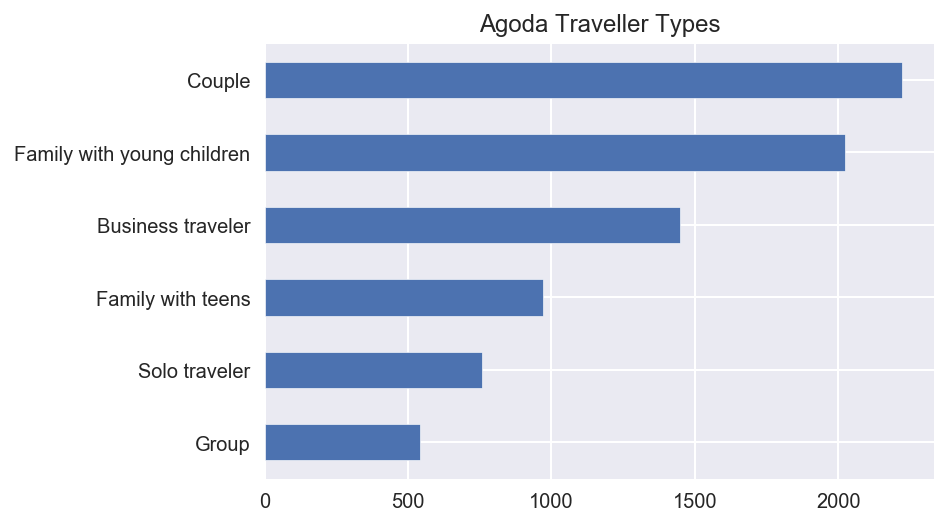

In [26]:
pd.Series(reviews_agd['trip_type']).value_counts().sort_values(ascending=True).plot('barh')
plt.title('Agoda Traveller Types')
plt.show()

In [27]:
reviews_agd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7968 entries, 0 to 8893
Data columns (total 7 columns):
date_of_stay     7968 non-null period[M]
trip_type        7968 non-null object
review           7968 non-null object
nationality      7896 non-null object
month_of_stay    7968 non-null object
year_of_stay     7968 non-null object
source           7968 non-null object
dtypes: object(6), period[M](1)
memory usage: 498.0+ KB


In [28]:
reviews_agd.head(3)

,date_of_stay,trip_type,review,nationality,month_of_stay,year_of_stay,source
0,2019-02,Group,LOVED MY STAY! ” I was in Singapore to celebra...,Thailand,February,2019,Agoda
1,2019-02,Family with young children,Hotel at the heart of orchard road” Very good ...,Singapore,February,2019,Agoda
2,2019-02,Family with young children,"Excellent” Location, location. Got upgraded to...",Brunei Darussalam,February,2019,Agoda


- agoda date_of_stay range = nov 2008 to feb 2019

### Combine TA and Agoda into one dataframe

In [29]:
all_reviews = reviews_ta.append(reviews_agd, sort=True).sort_values('date_of_stay', ascending=True).reset_index(drop=True)

In [30]:
# convert year_of_stay to integer
all_reviews['year_of_stay'] = all_reviews['year_of_stay'].astype(int)

In [31]:
# keep reviews from 2010 to now
all_reviews = all_reviews[all_reviews['year_of_stay'] >= 2010].reset_index(drop=True)

In [32]:
all_reviews

,date_of_stay,hotel_response,month_of_stay,nationality,review,source,trip_type,year_of_stay
0,2010-01,NaN,January,Malaysia,Brunei” overall am satisfied as the hotel is ...,Agoda,Couple,2010
1,2010-01,NaN,January,Indonesia,great week-end at Mandarin Meritus” It's been ...,Agoda,Group,2010
2,2010-01,NaN,January,Malaysia,Favourite Hotel !” Mandarin Meritus has always...,Agoda,Business traveler,2010
3,2010-01,NaN,January,Malaysia,nice” very nice hotel. nice food and great roo...,Agoda,Couple,2010
4,2010-01,NaN,January,Indonesia,"meritus orchard” Very nice hotel,location real...",Agoda,Couple,2010
5,2010-01,NaN,January,Malaysia,"Meritus Mandarin, Singapore” The location of t...",Agoda,Couple,2010
6,2010-01,NaN,January,Malaysia,Meitus Mandrin - Ben's Review” This is my seco...,Agoda,Couple,2010
7,2010-01,NaN,January,United Kingdom,Very old hotel” Partly refurbished notel - mai...,Agoda,Business traveler,2010
8,2010-01,NaN,January,Indonesia,spacious hotel room and great location” the ro...,Agoda,Couple,2010
9,2010-01,NaN,January,Australia,Meritus Mandarin” Great value 5 star-hotel in ...,Agoda,Business traveler,2010


In [33]:
all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17789 entries, 0 to 17788
Data columns (total 8 columns):
date_of_stay      17789 non-null period[M]
hotel_response    10133 non-null float64
month_of_stay     17789 non-null object
nationality       7584 non-null object
review            17789 non-null object
source            17789 non-null object
trip_type         17332 non-null object
year_of_stay      17789 non-null int64
dtypes: float64(1), int64(1), object(5), period[M](1)
memory usage: 1.1+ MB


In [34]:
# # export to csv, use tableau to visualise
# all_reviews.to_csv('./Data/all_reviews_from2010.csv', index=False)

# Generate clean review for sentiment analysis and topic modelling

In [40]:
nltk_sw = stopwords.words('english')
sklearn_sw = list(ENGLISH_STOP_WORDS)
sw = nltk_sw + sklearn_sw
stopwords = list(set(sw))

all_reviews['review_clean'] = all_reviews['review']

In [42]:
# remove non english words - if word does not start with a-z or 1-9, replace with ' '
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r'[^a-zA-Z0-9]', ' ')

In [43]:
all_reviews['review_clean'] = all_reviews['review_clean'].str.lower()
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"what's", 'what is')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"\'s", ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"\'ve'", 'have')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"can't", 'cannot')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"n't", ' not')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"i'm", 'i am')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"\'re", ' are')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"\'d", ' would')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r"\'ll", ' will')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\W', ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\s+', ' ')
# all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\[.*?\]', ' ')
# all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('[%s]' % re.escape(string.punctuation), ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\w*\d\w*', ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('[‘’“”…]', ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\n', ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('\r', ' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace('[^\w\s]',' ')
all_reviews['review_clean'] = all_reviews['review_clean'].str.replace(r'\d+', '')

In [44]:
all_reviews.head()

,date_of_stay,hotel_response,month_of_stay,nationality,review,source,trip_type,year_of_stay,review_clean
0,2010-01,NaN,January,Malaysia,Brunei” overall am satisfied as the hotel is ...,Agoda,Couple,2010,brunei overall am satisfied as the hotel is ve...
1,2010-01,NaN,January,Indonesia,great week-end at Mandarin Meritus” It's been ...,Agoda,Group,2010,great week end at mandarin meritus it s been a...
2,2010-01,NaN,January,Malaysia,Favourite Hotel !” Mandarin Meritus has always...,Agoda,Business traveler,2010,favourite hotel mandarin meritus has always be...
3,2010-01,NaN,January,Malaysia,nice” very nice hotel. nice food and great roo...,Agoda,Couple,2010,nice very nice hotel nice food and great room ...
4,2010-01,NaN,January,Indonesia,"meritus orchard” Very nice hotel,location real...",Agoda,Couple,2010,meritus orchard very nice hotel location reall...


### Lemmatize using spacy

In [45]:
import spacy
nlp = spacy.load('en', disable=["parser", "tagger", "ner"])

In [46]:
def lemma(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [47]:
all_reviews['review_clean'] = all_reviews['review_clean'].apply(lemma)

In [48]:
all_reviews.head()

,date_of_stay,hotel_response,month_of_stay,nationality,review,source,trip_type,year_of_stay,review_clean
0,2010-01,NaN,January,Malaysia,Brunei” overall am satisfied as the hotel is ...,Agoda,Couple,2010,brunei overall be satisfy a the hotel be very ...
1,2010-01,NaN,January,Indonesia,great week-end at Mandarin Meritus” It's been ...,Agoda,Group,2010,great week end at mandarin meritus it s be alm...
2,2010-01,NaN,January,Malaysia,Favourite Hotel !” Mandarin Meritus has always...,Agoda,Business traveler,2010,favourite hotel mandarin meritus have always b...
3,2010-01,NaN,January,Malaysia,nice” very nice hotel. nice food and great roo...,Agoda,Couple,2010,nice very nice hotel nice food and great room ...
4,2010-01,NaN,January,Indonesia,"meritus orchard” Very nice hotel,location real...",Agoda,Couple,2010,meritus orchard very nice hotel location reall...


In [ ]:
all_reviews.to_pickle('./Data/all_reviews_clean.pkl')

### Generate wordcloud

In [ ]:
# create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=stopwords)
all_reviews_cv = cv.fit_transform(all_reviews['review_clean'])
all_reviews_dtm = pd.DataFrame(all_reviews_cv.toarray(), columns=cv.get_feature_names())
all_reviews_dtm.index = all_reviews.index
all_reviews_dtm.head()

In [ ]:
all_reviews_dtm.shape

In [ ]:
all_reviews['review_clean'][9]

In [ ]:
all_reviews_dtm.sum(axis=0).sort_values(ascending=False).head(50)

In [ ]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=5
#         ,random_state = 1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(all_reviews['review_clean'])

In [ ]:
# all_reviews_dtm.to_pickle('./Data/all_reviews_dtm.pkl')
# pickle.dump(cv, open("./Data/cv.pkl", "wb"))